# AHSN Project
#### Done by:
Safeyah Alshemali - Hannah  Portes - Aparna Muraleekrishnan

#### Based on Paper: 
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications
[link](https://https://arxiv.org/abs/1704.04861)

#### Authors: 
Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam


### Code Libraries

Below is the process of loading the data of Imagenette. This tensorflow dataset has 10 classes, 9469 training samples, and 3925 validation samples.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import os

# Import Necessary Modules
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from keras import datasets, layers, models
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Activation , DepthwiseConv2D, Conv2D, BatchNormalization,  GlobalAveragePooling2D, Activation , Lambda , Reshape
from keras.preprocessing.image import ImageDataGenerator

### Data Processing

The data set we are using is **Imagenette** which is subset of ImageNet dataset of 10 classes only. This dataset fit the resourses (GPUS) and time limitation [link](https://https://www.tensorflow.org/datasets/catalog/imagenette).

In [2]:
# load the data and info from tfds
data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)

# then split into training and validation subsets
train_data, valid_data = data['train'], data['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/160px-v2/1.0.0.incompleteSATJHE/imagenette-train.tfrecord*...:   0%…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/160px-v2/1.0.0.incompleteSATJHE/imagenette-validation.tfrecord*...:…

Dataset imagenette downloaded and prepared to ~/tensorflow_datasets/imagenette/160px-v2/1.0.0. Subsequent calls will reuse this data.


In [3]:
image_size = 128
no_classes = 10
# resize the images to 128 x 128 for faster training 
train_dataset = train_data.map(lambda image, label: (tf.image.resize(image, (image_size, image_size)), label))

validation_dataset = valid_data.map(
    lambda image, label: (tf.image.resize(image, (image_size, image_size)), label))

In [4]:
# print general properties of the dataset for information and to verify attributes
# match what we expect
num_train = train_dataset.__len__().numpy()
num_val = validation_dataset.__len__().numpy()

num_classes = info.features['label'].num_classes
print('Total number of classes in dataset: ', num_classes)
print('Number of training samples: ', num_train)
print('Number of validation samples: ', num_val)

Total number of classes in dataset:  10
Number of training samples:  9469
Number of validation samples:  3925


In [5]:
# put train and validation into a list, and one hot encode their respective labels
X_train = list(map(lambda x: x[0], train_dataset))
y_train = list(map(lambda x: x[1], train_dataset))


X_valid = list(map(lambda x: x[0], validation_dataset))
y_valid = list(map(lambda x: x[1], validation_dataset))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

In [6]:
# Verify shapes
print('Y Train shape: {}'.format(y_train.shape))
print('Y Validation shape: {}'.format(y_valid.shape))
     

Y Train shape: (9469, 10)
Y Validation shape: (3925, 10)


### Data Augmentation

In [7]:
# Define ImageGen for data augmentation 

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      height_shift_range=0.3)

valid_datagen = ImageDataGenerator(
      rescale=1./255)

train_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_train), y=np.array(y_train), image_data_generator=train_datagen,batch_size=32
)

valid_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_valid), y=np.array(y_valid), image_data_generator=valid_datagen,batch_size=32
)

### Data Visualization 

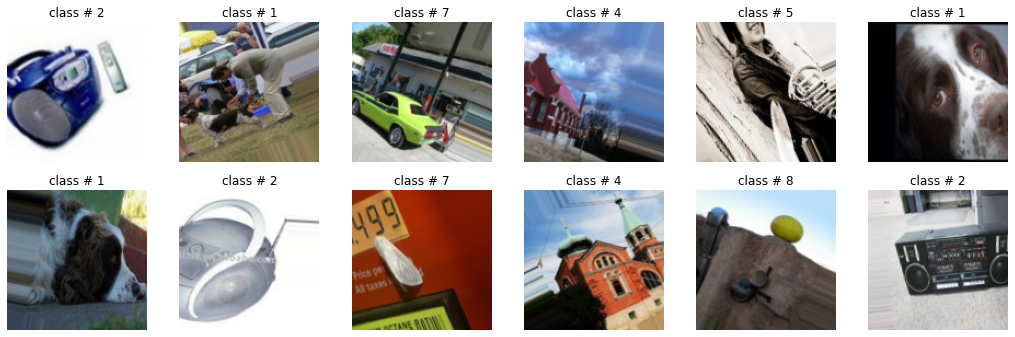

In [8]:
# plot the images
plt.figure(figsize=(18, 18))

num = 0

for i in range(0, 12):
    image,label = next(iter(train_data))
    ax = plt.subplot(6, 6, num + 1)
    plt.imshow(image[0])
    plt.title('class # ' + str(np.argmax(label)))
    plt.axis("off")
    num += 1


### MobileNet Model

The Depthwise Separable Convolution layer

In [9]:
# Function for Depth-wise Convolution Layer
def DepthWiseConv(kernal_size, stride, x):
    result = DepthwiseConv2D(kernal_size, strides=stride , padding='same')(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [10]:
# Function for Point-wise Convolution Layer
def PointWiseConv(filters,alpha,kernal_size, stride, x):
    result = Conv2D(int(alpha*filters), kernel_size=kernal_size, strides=stride)(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

Model Creation

In [34]:
def create_Reduced_MobileNet_model(input_shape, alpha ,no_classes):
    
    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #second layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(64,1,(1, 1), (1, 1) ,x)

    #third layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(128,1,(1, 1), (1, 1) ,x)
    
    #4th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(256,1,(1, 1), (1, 1) ,x)

    #5th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(512,1,(1, 1), (1, 1) ,x)

    #6th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(1024,1,(1, 1), (1, 1) ,x)

    #7th layer dropout 
    x = Dropout(0.2)(x)

    #8th layer: Avg Pooling
    x = GlobalAveragePooling2D()(x) 

    #9th layer Dense layer
    out = Dense(no_classes,activation='softmax')(x)

    model = Model(input, out, name='mobilenet')

    return model    

Fitting and Training the Model

In [42]:
MobileNet = create_Reduced_MobileNet_model((image_size,image_size,3),0.25,no_classes)
MobileNet.summary()


Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 32)        864       
                                                                 
 batch_normalization_55 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_55 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d_25 (Depthw  (None, 64, 64, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_56 (Bat  (None, 64, 64, 32)       12

In [36]:
#alpha = 1.00
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.7247 - accuracy: 0.4129
Epoch 1: saving model to ./tmp/checkpoint
296/296 [==============================] - 40s 129ms/step - loss: 1.7247 - accuracy: 0.4129 - val_loss: 3.4720 - val_accuracy: 0.1017
Epoch 2/25
296/296 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.5255
Epoch 2: saving model to ./tmp/checkpoint
296/296 [==============================] - 49s 165ms/step - loss: 1.4010 - accuracy: 0.5255 - val_loss: 2.3495 - val_accuracy: 0.2782
Epoch 3/25
296/296 [==============================] - ETA: 0s - loss: 1.2304 - accuracy: 0.5902
Epoch 3: saving model to ./tmp/checkpoint
296/296 [==============================] - 39s 131ms/step - loss: 1.2304 - accuracy: 0.5902 - val_loss: 1.4180 - val_accuracy: 0.5699
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.6303
Epoch 4: saving model to ./tmp/checkpoint
296/296 [==============================] - 38s

In [13]:
#alpha = 0.75
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.7464 - accuracy: 0.3999
Epoch 1: saving model to ./tmp/checkpoint
296/296 [==============================] - 61s 167ms/step - loss: 1.7464 - accuracy: 0.3999 - val_loss: 3.3145 - val_accuracy: 0.1017
Epoch 2/25
296/296 [==============================] - ETA: 0s - loss: 1.4311 - accuracy: 0.5275
Epoch 2: saving model to ./tmp/checkpoint
296/296 [==============================] - 48s 163ms/step - loss: 1.4311 - accuracy: 0.5275 - val_loss: 2.2106 - val_accuracy: 0.3162
Epoch 3/25
296/296 [==============================] - ETA: 0s - loss: 1.2710 - accuracy: 0.5813
Epoch 3: saving model to ./tmp/checkpoint
296/296 [==============================] - 50s 169ms/step - loss: 1.2710 - accuracy: 0.5813 - val_loss: 1.7055 - val_accuracy: 0.5302
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 1.1444 - accuracy: 0.6295
Epoch 4: saving model to ./tmp/checkpoint
296/296 [==============================] - 42s

In [40]:
!rm -rf ./tmp/*

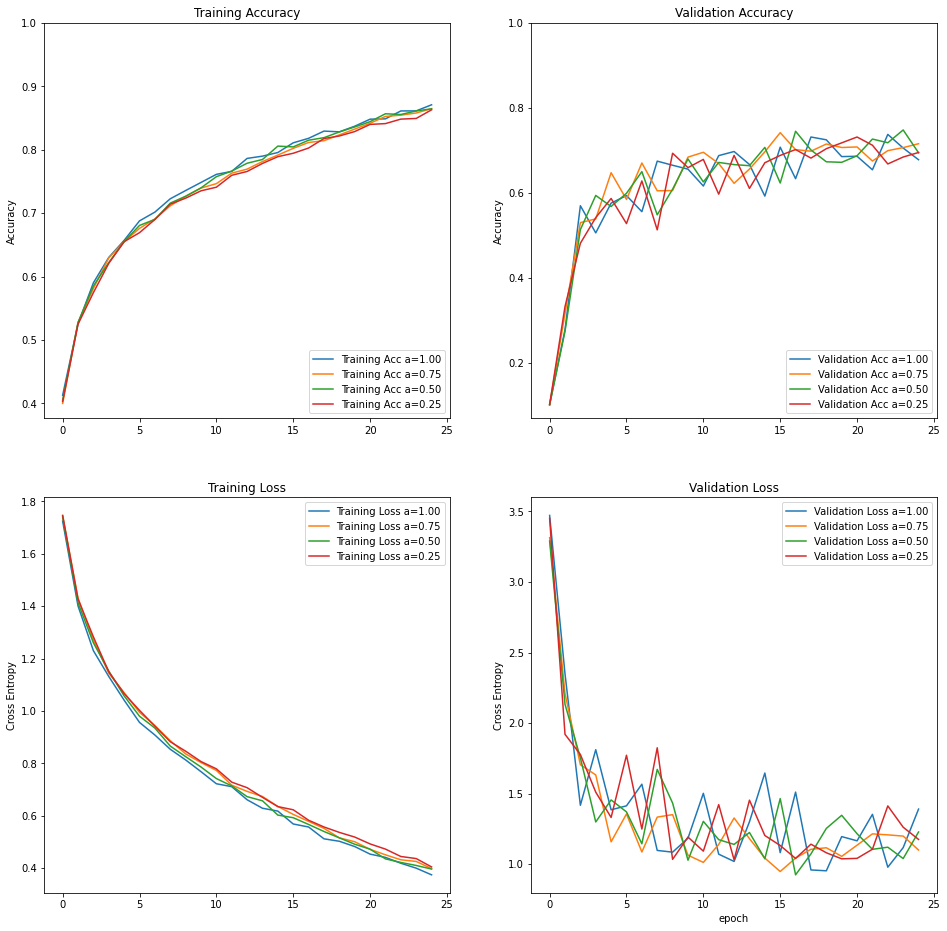

In [44]:
#plot the results 
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']

loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.plot(acc3, label='Training Acc a=1.00')
plt.plot(acc, label='Training Acc a=0.75')
plt.plot(acc1, label='Training Acc a=0.50')
plt.plot(acc2, label='Training Acc a=0.25')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(val_acc3, label='Validation Acc a=1.00')
plt.plot(val_acc, label='Validation Acc a=0.75')
plt.plot(val_acc1, label='Validation Acc a=0.50')
plt.plot(val_acc2, label='Validation Acc a=0.25')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(loss3, label='Training Loss a=1.00')
plt.plot(loss, label='Training Loss a=0.75')
plt.plot(loss1, label='Training Loss a=0.50')
plt.plot(loss2, label='Training Loss a=0.25')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')

plt.subplot(2, 2, 4)
plt.plot(val_loss3, label='Validation Loss a=1.00')
plt.plot(val_loss, label='Validation Loss a=0.75')
plt.plot(val_loss1, label='Validation Loss a=0.50')
plt.plot(val_loss2, label='Validation Loss a=0.25')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Validation Loss')

plt.xlabel('epoch')
plt.show()

In [39]:
del history, model_checkpoint_callback

In [19]:
#alpha = 0.50
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.7410 - accuracy: 0.4051
Epoch 1: saving model to ./tmp/checkpoint
296/296 [==============================] - 41s 133ms/step - loss: 1.7410 - accuracy: 0.4051 - val_loss: 3.2909 - val_accuracy: 0.1017
Epoch 2/25
296/296 [==============================] - ETA: 0s - loss: 1.4128 - accuracy: 0.5277
Epoch 2: saving model to ./tmp/checkpoint
296/296 [==============================] - 37s 126ms/step - loss: 1.4128 - accuracy: 0.5277 - val_loss: 2.1339 - val_accuracy: 0.2741
Epoch 3/25
296/296 [==============================] - ETA: 0s - loss: 1.2605 - accuracy: 0.5852
Epoch 3: saving model to ./tmp/checkpoint
296/296 [==============================] - 37s 125ms/step - loss: 1.2605 - accuracy: 0.5852 - val_loss: 1.7547 - val_accuracy: 0.5136
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 1.1526 - accuracy: 0.6222
Epoch 4: saving model to ./tmp/checkpoint
296/296 [==============================] - 38s

In [43]:
#alpha = 0.25
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.7460 - accuracy: 0.4031
Epoch 1: saving model to ./tmp/checkpoint
296/296 [==============================] - 43s 139ms/step - loss: 1.7460 - accuracy: 0.4031 - val_loss: 3.4512 - val_accuracy: 0.1017
Epoch 2/25
296/296 [==============================] - ETA: 0s - loss: 1.4274 - accuracy: 0.5249
Epoch 2: saving model to ./tmp/checkpoint
296/296 [==============================] - 37s 126ms/step - loss: 1.4274 - accuracy: 0.5249 - val_loss: 1.9211 - val_accuracy: 0.3325
Epoch 3/25
296/296 [==============================] - ETA: 0s - loss: 1.2830 - accuracy: 0.5747
Epoch 3: saving model to ./tmp/checkpoint
296/296 [==============================] - 37s 124ms/step - loss: 1.2830 - accuracy: 0.5747 - val_loss: 1.7779 - val_accuracy: 0.4815
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 1.1497 - accuracy: 0.6209
Epoch 4: saving model to ./tmp/checkpoint
296/296 [==============================] - 37s

### CNN Model

Standard Convolution Layer 

In [ ]:
def standard_Conv(filter,kernal_size, stride, x):
  x = Conv2D(filter, kernel_size=kernal_size, strides=stride ,padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

Model Creation

In [ ]:
def create_CNN_model(input_shape ,no_classes):
    
    filters = [32,64,128,256,512,1024]
    strides = [2,1,2,2,2,2]
    layers = len(filters)
    
    x = Input(shape= input_shape)

    for i in range(layers):
      x = Conv2D(filters[i], kernel_size=(3, 3), strides=(strides[i], strides[i]) ,padding='same', use_bias=False)(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

    # Dropout Layer 
    x = Dropout(0.2)(x)

    # Avg Pooling layer
    x = GlobalAveragePooling2D()(x) 

    # Dense layer
    out = Dense(no_classes,activation='softmax')(x)

    model = Model(input, out, name='mobilenet')

    return model    

Fitting and Training The Model

In [ ]:
MobileNet = create_Reduced_MobileNet_model((image_size,image_size,3),1,no_classes)
MobileNet.summary()


In [ ]:
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

In [ ]:
#plot the results 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()